# Trabajo Final

## Understanding Elon Musk Emotions Over Time

In [48]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams


nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
import random

from collections import Counter
from wordcloud import WordCloud

import emoji

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/puriarte/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/puriarte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/puriarte/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/puriarte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
bd_tw = pd.read_csv('Data/elonmusk.csv')

In [3]:
bd_tw.head()

,Datetime,Tweet Id,Text,Username
0,2023-05-29 22:22:12+00:00,1663309794659168256,@mattyglesias Now answer the question,elonmusk
1,2023-05-29 22:21:43+00:00,1663309674194649089,@mattyglesias Insufferable numbskull,elonmusk
2,2023-05-29 21:33:29+00:00,1663297534062673920,@EndWokeness Yes,elonmusk
3,2023-05-29 20:04:12+00:00,1663275065696239653,@SethDillon 🤣,elonmusk
4,2023-05-29 19:44:54+00:00,1663270209598246912,@TeslaOwnersEBay @stevenmarkryan @WholeMarsBlo...,elonmusk


In [4]:
bd_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  23501 non-null  object
 1   Tweet Id  23501 non-null  int64 
 2   Text      23501 non-null  object
 3   Username  23501 non-null  object
dtypes: int64(1), object(3)
memory usage: 734.5+ KB


In [5]:
# Checking for NaN just in case.
nan_check = bd_tw.isna().any()
nan_check

Datetime    False
Tweet Id    False
Text        False
Username    False
dtype: bool

### Working on the database

Well do some changes to the df so its easier to use as well as some basic cleaning

    -Standarize column names turn to lower case.
    -Columns "tweet_id" & "username" not really useful so we can drop them
    -We'll split the "datetime" column so we can be better at splitting periods of time and hours of the day later in the analysis
    




In [6]:
## Change column names to lower case and remove spaces
bd_tw.columns = [col.lower().replace(' ', '_') for col in bd_tw.columns]

In [7]:
## Convert the "datetime" column to datetime format
bd_tw['datetime'] = pd.to_datetime(bd_tw['datetime'])

## Create new 'date' column
bd_tw['date'] = bd_tw['datetime'].dt.date

## Create new 'hour' column
bd_tw['hour'] = bd_tw['datetime'].dt.hour

In [8]:
# Convert 'date' column to datetime object
bd_tw['date'] = pd.to_datetime(bd_tw['date'])

In [10]:
##Drop unuseful columns
bd_tw.drop(columns=['tweet_id', 'username'], inplace=True)
bd_tw.drop(columns=['datetime'], inplace=True)

#making every letter to be lower case
bd_tw['text'] = bd_tw['text'].str.lower()

In [11]:
# Reorder your DataFrame
bd_tw = bd_tw[['date', 'hour', 'text']]



### Text Data Preprocessing

#### For our NLP work we need to do some preprocessing of out data, especially the text column data.

    -1 Create a new text column free of usernames, emojis 
    -2 Remove stop words. 
    -3 Tokenize the text
    -4 Remove URLs
    -5 Remove non-alphabetic characters
    -6 Lemmatize the text


#### Notes:
   
    -Final working column will be "lemmatized_text"
    -I kept the original "text" column and the "proprocessed text"(which keeps non-alphabetic characters just in case we can use those later)
    
    

In [39]:
#1 Create a new text column free of usernames, emojis
#2 Remove stop words 
#3 Tokenize the text

# Define the set of stop words
stop_words = set(stopwords.words('english'))

def preprocess_text_sw(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    text = emoji.demojize(text)
    text = re.sub(r':[a-zA-Z_&]+:', '', text)

    # Tokenize the words
    word_tokens = word_tokenize(text)

    # Filter out the stop words
    filtered_text = [word for word in word_tokens if not word in stop_words]

    return " ".join(filtered_text)

# Apply the preprocessing to the text column
bd_tw['preprocessed_text'] = bd_tw['text'].apply(preprocess_text_sw)


In [42]:
#4 Remove URLs
def remove_urls(text):
    url_pattern = re.compile(r'(https?|www)[\s:/.A-Za-z0-9]*|//t\.co/\S*')
    return url_pattern.sub(r'', text)

# Apply the URL removal to the preprocessed_text column
bd_tw['preprocessed_text'] = bd_tw['preprocessed_text'].apply(remove_urls)




In [99]:
#5 Remove non-alphabetic characters
def preprocess_lemmatize_text(text):
    # Replace underscores with spaces
    text = re.sub(r'_', ' ', text)
    
    # Remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

# Apply the preprocessing to the preprocessed_text column and store the result in a new column
bd_tw['lemmatized_text'] = bd_tw['preprocessed_text'].apply(preprocess_lemmatize_text)


In [100]:
#6 Lemmatize the text

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# This function converts nltk pos-tags to WordNet pos-tags
def get_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    nltk_pos_tagged = pos_tag(word_tokenize(text))
    wordnet_pos_tagged = list(map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_pos_tagged))
    lemmatized_text = list(map(lambda x: lemmatizer.lemmatize(x[0], pos=x[1]), wordnet_pos_tagged))
    return " ".join(lemmatized_text)

# Apply the lemmatization to the lemmatized_text column
bd_tw['lemmatized_text'] = bd_tw['lemmatized_text'].apply(lemmatize_text)

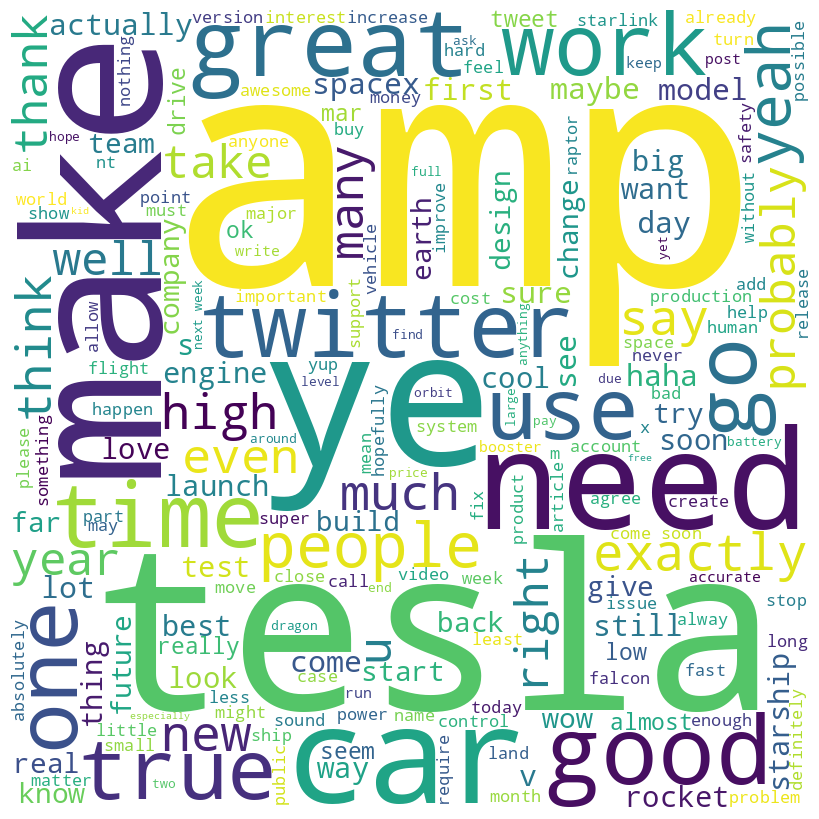

In [51]:
#FIRST WORD CLOUD
# Concatenate all the preprocessed text together
all_text = ' '.join(bd_tw['lemmatized_text'])

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(all_text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### Feature engineering


#### We'll also test some new columns.

    -Creat a new column with the @users tagged in the twits
    -Well use named entity recognition to see what other information we can get
    
    -1. Add a new column for text length
    -2. A regular expression to match any emoji
    -3. Creating a new column called "usernames"
    
    
   #### Notas:
   
       -Necesito hacer que los emojis solo aparezcan una vez en la columna emoji

In [127]:
bd_tw.head(60)

,date,year,month,hour,text,text_length,usernames,emoji,preprocessed_text,lemmatized_text
0,2023-05-29,2023,5,22,@mattyglesias now answer the question,37,@mattyglesias,,answer question,answer question
1,2023-05-29,2023,5,22,@mattyglesias insufferable numbskull,36,@mattyglesias,,insufferable numbskull,insufferable numbskull
2,2023-05-29,2023,5,21,@endwokeness yes,16,@endwokeness,,yes,yes
3,2023-05-29,2023,5,20,@sethdillon 🤣,13,@sethdillon,🤣,,
4,2023-05-29,2023,5,19,@teslaownersebay @stevenmarkryan @wholemarsblo...,107,"@teslaownersebay,@stevenmarkryan,@wholemarsblo...",,later year . definitely needs happen !,later year definitely need happen
5,2023-05-29,2023,5,19,"also, you can now change video playback speed",45,NaN,,"also , change video playback speed",also change video playback speed
6,2023-05-29,2023,5,19,@krassenstein this is pretty cool,33,@krassenstein,,pretty cool,pretty cool
7,2023-05-29,2023,5,19,@stevenmarkryan @wholemarsblog heard diablo iv...,94,"@stevenmarkryan,@wholemarsblog",,heard diablo iv might good . remake system sho...,heard diablo iv might good remake system shock...
8,2023-05-29,2023,5,18,@joeys_lady @stevenmarkryan @wholemarsblog true,47,"@joeys_lady,@stevenmarkryan,@wholemarsblog",,true,true
9,2023-05-29,2023,5,18,@drknowitall16 coming soon,26,@drknowitall16,,coming soon,come soon


In [81]:
# 1. Add a new column for text length
bd_tw.loc[:, 'text_length'] = bd_tw['text'].str.len()

In [126]:
#2. A regular expression to match any emoji
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Define a function that extracts unique emojis from a string
def extract_unique_emojis(text):
    emojis = re.findall(emoji_pattern, text)
    unique_emojis = list(set(emojis))
    return ', '.join(unique_emojis)

# Apply the function to the 'text' column and assign the result to the 'emoji' column
bd_tw['emoji'] = bd_tw['text'].apply(extract_unique_emojis)



In [19]:
#3. Creating a new column called "usernames"
bd_tw['usernames'] = bd_tw['text'].str.extractall(r'(@\w+)')[0].groupby(level=0).apply(','.join)


Columna de TEXT tokenized

In [102]:
# List your columns in the order you want them
columns_ordered = ['date','year', 'month', 'hour', 'text', 'text_length', 'usernames', 'emoji','preprocessed_text','lemmatized_text']

# Select your columns in the order listed
bd_tw = bd_tw[columns_ordered]


#### The data base:
    -Records twits from 2010-06-04 to 2023-05-29
    -Has emojis (which can help the sentiment analysis)
    -"@" refers to people (which we can try to use to valuate sentiments with other people)

#### EDA & GEDA

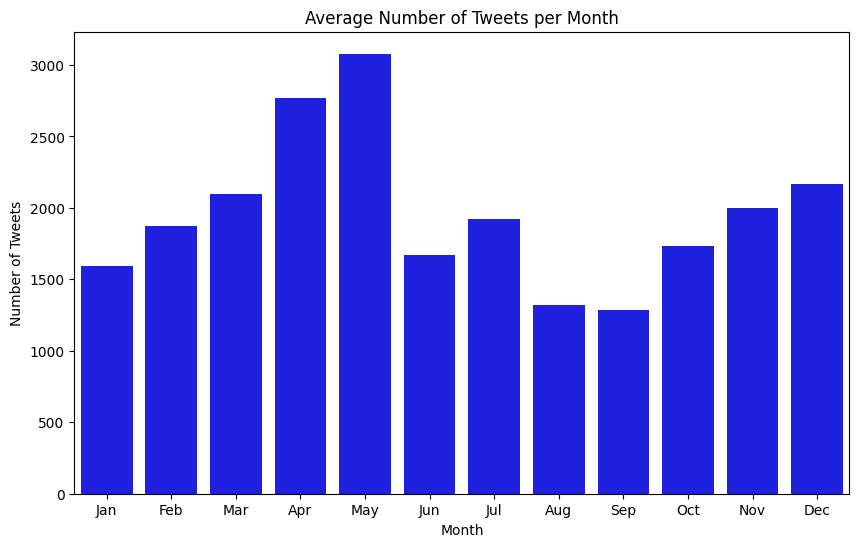

In [21]:
# Extract month from date column
bd_tw['month'] = bd_tw['date'].dt.month
# Calculate tweet counts for each month
monthly_tweets = bd_tw['month'].value_counts().sort_index()

# Generate the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_tweets.index, y=monthly_tweets.values, color='b')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.title('Average Number of Tweets per Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [53]:
# Get a Series with usernames as index and their counts as values
username_counts = bd_tw['usernames'].value_counts()

# Convert the Series to a DataFrame for better visualisation
username_counts_df = username_counts.reset_index()

# Rename the columns for clarity
username_counts_df.columns = ['usernames', 'count']

# Display the DataFrame
print(username_counts_df)


                                         usernames  count
0                                   @wholemarsblog    331
1                                        @billym2k    276
2                                   @teslaownerssv    183
3                                  @erdayastronaut    126
4                                        @ppathole    122
...                                            ...    ...
9967  @doge_southern,@truth_tesla,@consumerreports      1
9968                                    @sluigi123      1
9969                     @cmuratori,@id_aa_carmack      1
9970                       @tesla4k,@matanmazursky      1
9971                                    @jonlovett      1

[9972 rows x 2 columns]


In [55]:
print(username_counts_df.head(50))


           usernames  count
0     @wholemarsblog    331
1          @billym2k    276
2     @teslaownerssv    183
3    @erdayastronaut    126
4          @ppathole    122
5     @rainmaker1973    115
6           @cb_doge    114
7     @cleantechnica    108
8           @flcnhvy    104
9           @evafoxu     99
10        @teslarati     97
11           @spacex     84
12   @engineers_feed     83
13   @wallstreetsilv     80
14       @trungtphan     79
15       @nichegamer     77
16       @lexfridman     74
17    @thebabylonbee     74
18      @sciguyspace     72
19       @waitbutwhy     67
20    @sawyermerritt     67
21        @stillgray     65
22         @slashdot     61
23       @davidsacks     61
24   @muskuniversity     60
25        @micsolana     56
26           @pmarca     56
27    @id_aa_carmack     55
28  @nasaspaceflight     54
29  @dogeofficialceo     51
30    @westcoastbill     47
31    @tesmanian_com     46
32  @kanekoathegreat     44
33            @jason     43
34              @alx

In [56]:
bd_tw['year'] = bd_tw['date'].dt.year


In [59]:
# Group by year and username, count the number of occurrences of each pair
username_counts_year = bd_tw.groupby(['year', 'usernames']).size()

# Iterate over each year and print the top usernames
for year in bd_tw['year'].unique():
    top_usernames = username_counts_year[year].nlargest(10)
    print(f"Top usernames for year {year}:")
    print(top_usernames)
    print()


Top usernames for year 2023:
usernames
@billym2k           97
@cb_doge            96
@wallstreetsilv     66
@wholemarsblog      59
@thebabylonbee      47
@trungtphan         43
@kanekoathegreat    42
@alx                41
@dogeofficialceo    41
@teslaownerssv      41
dtype: int64

Top usernames for year 2022:
usernames
@wholemarsblog    152
@billym2k         138
@teslaownerssv     59
@rainmaker1973     51
@evafoxu           43
@ppathole          41
@pmarca            39
@sawyermerritt     37
@stillgray         36
@lexfridman        31
dtype: int64

Top usernames for year 2021:
usernames
@wholemarsblog      96
@teslaownerssv      45
@billym2k           41
@ppathole           37
@erdayastronaut     26
@rainmaker1973      26
@lexfridman         24
@thesheetztweetz    23
@engineers_feed     22
@cleantechnica      21
dtype: int64

Top usernames for year 2020:
usernames
@flcnhvy           58
@teslarati         48
@cleantechnica     45
@erdayastronaut    44
@ppathole          41
@thirdrowtes

KeyError: 2010

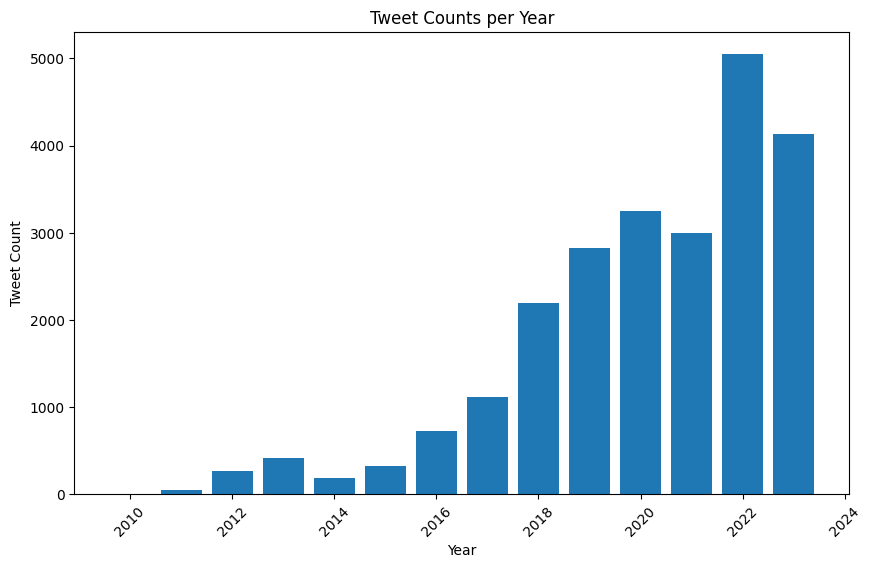

In [60]:

# Group by year and count the number of tweets per year
tweet_counts_per_year = bd_tw['year'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(tweet_counts_per_year.index, tweet_counts_per_year.values)
plt.xlabel('Year')
plt.ylabel('Tweet Count')
plt.title('Tweet Counts per Year')
plt.xticks(rotation=45)
plt.show()

In [128]:
unique_emojis = bd_tw['emoji'].unique()
print(unique_emojis)

['' '🤣' '🇺🇸' '🔥' '🤨' '🤔' '💯' '🤣🤣' '👀' '😬' '🦾' '🧐' '🎯' '🧠🕹️🤔' '💪' '♂️, 🤷'
 '🖤' '😂' '🇺🇸🇺🇸' '🍿😀' '🪦' '🔥🔥' '🤗' '🍻' '🤣👍🏻' '👍🏻' '👏' '🚽' '♾️' '😲' '🤯🤯'
 '😵, 💫' '😳' '🤣🎯' '🤯' '💩, 😂' '♥️♥️' '🥲🤣' '🩸, 🌹, 🪶' '🔥🤣' '👏, 🐈, 🎣' '🏆' '😜'
 '😂💯' '🤣, 😬' '🦇' '😃' '💕' '😔' '😢' '🙌' '❤️' '👖, 🔥' '😎' '👾👾' '🧠, 🦫' '🎶' '🇦🇪'
 '😅' '❗️' '🍷, 🧀' '🙏' '\U0001fae1' '♂️, 🤦' '🥜' '🤩' '🤭' '💡' '💯🤣' '😋' '🥰' '💩'
 '😭' '🚀' '🍳' '🪴, 🤣, 🧟, ♂️' '🙈' '☺️, \U0001f9cc' '😊' '💦' '⚠️' '😑' '☺️' '😌'
 '🐉, 🔥' '🤣🔥' '🍩' '☕️, 📱' '🔥🔥, 🤣🤣' '♂️, 🙋' '💅' '👋' '📈📉' '🚀, 💫, 💗' '💩, 🏦, 🔥'
 '🛸' '😞' '🕰️' '😉' '💔' '♥️♥️♥️' '🛌' '🍀' '♥️' '🎂' '😈' '🚬'
 '💨, 🎶, 😢, 🦾, 🧘, 😑, ♥️, \U0001f9cc, ⭐️, 💫, 😈, ⚔️, ✌️, 🌎, 😭, 😇, 🪦, 😮' '🤣💯'
 '🛰️, 💫' '🧨' '🥳' '😢, 🔥🤣' '🤞' '🐈' '🥇' '🇸🇪' '⚔️' '🤣🤣🤣' '🤬, 😂' '🧵'
 '\U0001f9cc' '🔥💯' '😮' '⚜️' '🏴, ☠️' '🌶️, 🔥' '😠' '🤣, 🔥' '🍆' '🔥, 🚽, 🤫' '👆'
 '♥️, ⚡️' '😋, 🍦' '🎈🎈, 🤣🤣' '🛸, 👽' '🇯🇵🇯🇵' '📜' 'わかりました' '🤣, 💣' '🐥' '🇲🇽' '🐝'
 '😴' '\U0001f979' '🥳🥳' '🛡️' '🚀, ♥️, 💫' '🙄' '🍿' '🇳🇴' '🦜' '♥️, 🤖' '🤣🤣🔥🔥' '🥁'
 '😀' '🔥🔥, 💰, 💰🔥🔥' '🇦🇷, 🇫🇷' '🇫🇷🇫🇷🇫🇷' '🇦🇷🇦🇷🇦🇷' '🔥🔥🔥' '💥💥💥💥💥' '🔥🔥🔥🔥'
 '🪄,

In [130]:
# Create a new column 'emoji' and initialize it as empty
bd_tw['emoji'] = ''

# Iterate over each row in the DataFrame
for index, row in bd_tw.iterrows():
    text = row['text']
    emojis = re.findall(emoji_pattern, text)
    unique_emojis = set(emojis)
    bd_tw.at[index, 'emoji'] = ' '.join(unique_emojis)

# Count the occurrences of each emoji
emoji_counts = bd_tw['emoji'].str.split(expand=True).stack().value_counts()

# Print the most appeared emojis
print("Top appeared emojis:")
print(emoji_counts.head())




Top appeared emojis:
🤣     545
🤣🤣    364
💯     124
🔥🔥     78
🔥      56
dtype: int64
